Step 4 : 딥러닝 모델 (CNN) 정의 및 학습 단계

목표

입력 : X_positive.npy (51,7) , y_positive.npy (1)

모델 : CNN 기반 classifier

출력 : 학습된 모델(.pt), 검증 성능, ROC/PR 곡선

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 전체 데이터를 불러옴
X = np.load("../data/features/X_all.npy")
y = np.load("../data/features/y_all.npy")

# 먼저 train + temp(val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 그 다음 temp에서 val/test 나눔
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [3]:
# 각 세트 크기 확인
print(f"Train: {len(y_train)} samples")
print(f"Val  : {len(y_val)} samples")
print(f"Test : {len(y_test)} samples")

# 클래스 분포 (0과 1의 개수)
def print_label_counts(name, y):
    labels, counts = np.unique(y, return_counts=True)
    print(f"{name} label distribution:")
    for l, c in zip(labels, counts):
        print(f"  Class {int(l)}: {c} ({c/len(y)*100:.2f}%)")
    print()

print_label_counts("Train", y_train)
print_label_counts("Val", y_val)
print_label_counts("Test", y_test)

Train: 28131 samples
Val  : 6028 samples
Test : 6029 samples
Train label distribution:
  Class 0: 14065 (50.00%)
  Class 1: 14066 (50.00%)

Val label distribution:
  Class 0: 3014 (50.00%)
  Class 1: 3014 (50.00%)

Test label distribution:
  Class 0: 3015 (50.01%)
  Class 1: 3014 (49.99%)



In [4]:
# Dataset 정의
class RNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = RNADataset(X_train, y_train)
val_ds = RNADataset(X_val, y_val)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

# CNN 모델 정의
class LIN28ACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(7, 128, kernel_size=8)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=6)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.out(x)).squeeze(-1)

# 모델 + 학습 도구
model = LIN28ACNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


In [5]:
print("val set label 분포:", np.unique(y_val, return_counts=True))

val set label 분포: (array([0., 1.], dtype=float32), array([3014, 3014]))


In [6]:
# 학습 루프
train_losses = []
val_aucs = []
best_auc = 0

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)

    # 평가
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(yb.cpu().numpy())

    auc = roc_auc_score(val_true, val_preds)
    val_aucs.append(auc)
    scheduler.step(auc)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f} | Val AUROC: {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "../models/best_model.pt")
        print("✅ 모델 저장 (AUROC 개선됨)")

Epoch  1 | Loss: 0.5922 | Val AUROC: 0.8510
✅ 모델 저장 (AUROC 개선됨)
Epoch  2 | Loss: 0.4425 | Val AUROC: 0.8926
✅ 모델 저장 (AUROC 개선됨)
Epoch  3 | Loss: 0.3897 | Val AUROC: 0.9079
✅ 모델 저장 (AUROC 개선됨)
Epoch  4 | Loss: 0.3550 | Val AUROC: 0.9188
✅ 모델 저장 (AUROC 개선됨)
Epoch  5 | Loss: 0.3309 | Val AUROC: 0.9254
✅ 모델 저장 (AUROC 개선됨)
Epoch  6 | Loss: 0.3098 | Val AUROC: 0.9310
✅ 모델 저장 (AUROC 개선됨)
Epoch  7 | Loss: 0.2913 | Val AUROC: 0.9351
✅ 모델 저장 (AUROC 개선됨)
Epoch  8 | Loss: 0.2714 | Val AUROC: 0.9386
✅ 모델 저장 (AUROC 개선됨)
Epoch  9 | Loss: 0.2534 | Val AUROC: 0.9413
✅ 모델 저장 (AUROC 개선됨)
Epoch 10 | Loss: 0.2369 | Val AUROC: 0.9447
✅ 모델 저장 (AUROC 개선됨)
Epoch 11 | Loss: 0.2209 | Val AUROC: 0.9472
✅ 모델 저장 (AUROC 개선됨)
Epoch 12 | Loss: 0.2067 | Val AUROC: 0.9497
✅ 모델 저장 (AUROC 개선됨)
Epoch 13 | Loss: 0.1911 | Val AUROC: 0.9518
✅ 모델 저장 (AUROC 개선됨)
Epoch 14 | Loss: 0.1766 | Val AUROC: 0.9534
✅ 모델 저장 (AUROC 개선됨)
Epoch 15 | Loss: 0.1589 | Val AUROC: 0.9552
✅ 모델 저장 (AUROC 개선됨)
Epoch 16 | Loss: 0.1477 | Val AUROC: 0.9

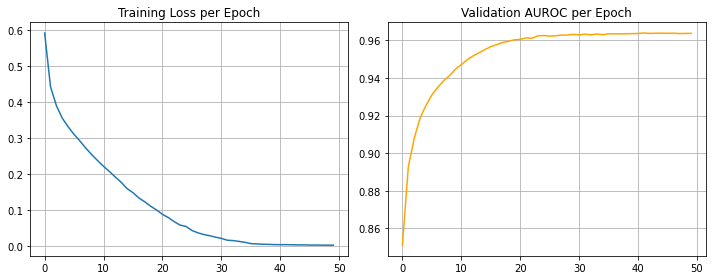

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_aucs, label="Validation AUROC", color="orange")
plt.title("Validation AUROC per Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import os

# 저장할 결과 테이블 생성
metrics_df = pd.DataFrame({
    "epoch": list(range(1, len(train_losses) + 1)),
    "train_loss": train_losses,
    "val_auc": val_aucs
})

# 저장 디렉토리 생성 후 저장
os.makedirs("../results/metrics", exist_ok=True)
metrics_df.to_csv("../results/metrics/val_metrics.csv", index=False)
print("✅ 저장 완료: val_metrics.csv")

✅ 저장 완료: val_metrics.csv


## 🧠 Step 4: LIN28A CNN 학습 (최종)

이 모델은 RNA 서열 및 구조 정보를 기반으로 LIN28A binding site를 분류하기 위해 학습됩니다.

### ✅ 구성
- 입력: (51, 7) one-hot RNA window
- 모델: 2-layer CNN + AdaptivePooling + FC
- 손실함수: BCELoss
- 평가 지표: AUROC
- GPU 자동 적용 + 학습률 스케줄러 적용

### ✅ 출력
- `../models/best_model.pt` (Val AUROC 기준 최고 성능)
